In [ ]:
import numpy as np
import json
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm # нормальное распределение 
from scipy import stats
from sklearn.preprocessing import StandardScaler
import catboost
from catboost import CatBoostClassifier, Pool


In [ ]:
df = pd.read_json('/train.json') 

In [ ]:
df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low


Оценим размер датасета.

In [ ]:
df.shape

(49352, 15)

Оценим количество пропусков и типы данных в датасете.

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB
None


Итого: во всём датасете нет ни одного пропуска, 6 столбцов с числовыми значениями, а остальные с объектовыми.

Описание признаков:

0. bathrooms - количество ванных комнат
1. bedrooms - количество спален
2. building_id - id строения
3. created - дата размещения
4. description - описание апартаментов
5. display_address - отображаемый адрес (?)
6. features - особенности
7. latitude - широта
8. listing_id - id объявления
9. longitude - долгота
10. manager_id - id владельца
11. photos - ссылки на фото
12. price - цена в долларах
13. street_address - улица
14. interest_level - целевая переменная. Уровень интереса к объявлению.

In [ ]:
df.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


## Предобработка данных

#### Признак bathrooms

Не совсем понятно почему тип данных для этог признака float, поэтому преобразуем его в int.

In [ ]:
df['bathrooms'] = df['bathrooms'].astype('int')

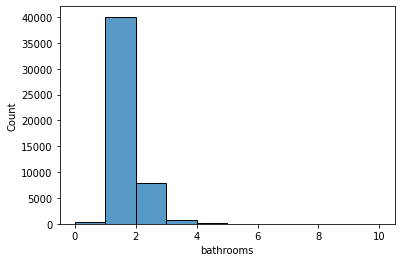

In [ ]:
sns.histplot(data= df, x='bathrooms',binwidth = 1)

In [ ]:
df.loc[((df['bathrooms'] == 0) | (df['bathrooms'] >= 4))].shape

(533, 15)

Как видим, в датасете присутствуют значения, где количество ванных комнат либо равно нулю, либо больше четырех. Будем считать такие значения выбросами и удалим их из датасета.

In [ ]:
df = df.loc[((df['bathrooms'] > 0) & (df['bathrooms'] < 4))]

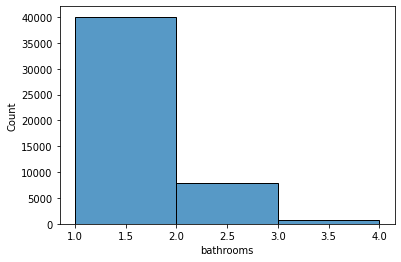

In [ ]:
sns.histplot(data= df, x='bathrooms', binwidth = 1 ,binrange = [1,4], element = 'bars')

#### Признак bedrooms

Определим количесво студий.

In [ ]:
df[df['bedrooms'] == 0].shape[0]

9317

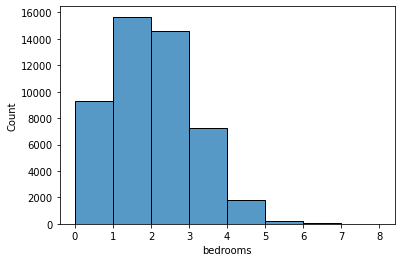

In [ ]:
sns.histplot(data= df, x='bedrooms', binwidth = 1)

Как видим, в датасете присутствуют значения, где количество спальных комнат может быть больше четырех. Будем считать такие значения выбросами и удалим их из датасета.

In [ ]:
df[df['bedrooms'] > 4].shape

(222, 15)

In [ ]:
df = df[df['bedrooms'] <= 4]

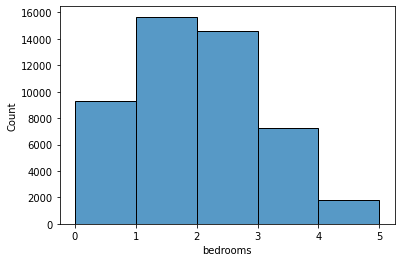

In [ ]:
sns.histplot(data= df, x='bedrooms', binwidth = 1, binrange = [0,5])

#### Признак building_id

In [ ]:
df['building_id'].value_counts()

0                                   8179
96274288c84ddd7d5c5d8e425ee75027     275
11e1dec9d14b1a9e528386a2504b3afc     214
bb8658a3e432fb62a440615333376345     212
80a120d6bc3aba97f40fee8c2204524b     212
                                    ... 
80b6723e1002c54dfd28d8c8cff69a61       1
f499cb726ebde29a2a6082ea061f65a7       1
63e7b6481175ab0c75c695d18abcbbb1       1
70d79b34eb380b8fcfdd3eb392271bd9       1
e125ca74a8353517f1c9dcc43fed068b       1
Name: building_id, Length: 7496, dtype: int64

Видим, что в 8179 объявлениях не указан building_id. В целом, признак малоинформативен, поэтому его можно удалить.

#### Признак created

In [ ]:
df['created'].head()

4     2016-06-16 05:55:27
6     2016-06-01 05:44:33
9     2016-06-14 15:19:59
10    2016-06-24 07:54:24
15    2016-06-28 03:50:23
Name: created, dtype: object

Идея: попробую преобразовать признак created из типа object в тип datetime и затем разделить его на месяц и год для дальнейшего исследования.

In [ ]:
df['date of publication'] = pd.to_datetime(df['created'], errors = 'coerce')   # coerce - если возникнет ошибка, вставить NaT

In [ ]:
df[df['date of publication'].isnull() == True].shape[0]

0

Без потерь преобразовали created в тип данных datetime. Теперь получим месяц и год публикации.

In [ ]:
df['month of publication'] = df['date of publication'].dt.month.astype('int')

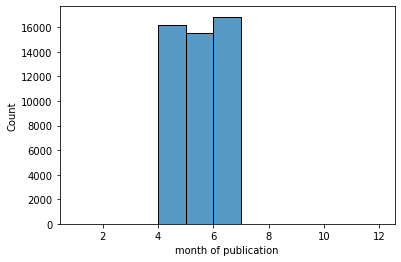

In [ ]:
sns.histplot(data= df, x='month of publication', binwidth = 1, binrange = [1,12])

In [ ]:
df['year of publication'] = df['date of publication'].dt.year.astype('int')

In [ ]:
df[df['year of publication'] != 2016].shape[0]

0

Все объявления выложены в 2016 году, следовательно 'year of publication' можно удалить, т.к. он бесполезен.

Таким образом, в дальнейшем исследуем зависимость целевой переменной от месяца публикации, а признаки created, date of publication, year of publication удалим за ненадобностью. 

#### Признак listing_id

Признак listing_id удалим, т.к. он бесполезен.

#### Признаки latitude и longitude

Признаки latitude и longitude оставим без изменений.

#### Признак manager_id

In [ ]:
df['manager_id'].value_counts()

e6472c7237327dd3903b3d6f6a94515a    2497
6e5c10246156ae5bdcd9b487ca99d96a     711
62b685cc0d876c3a1a51d63a0d6a8082     399
cb87dadbca78fad02b388dc9e8f25a5b     370
8f5a9c893f6d602f4953fcc0b8e6e9b4     351
                                    ... 
78d5262dbc517beb7105b1dd859243e6       1
545729ea0435a0d41c5bd4fe11a374fb       1
347fb4b4e2f436e96330f0ca8bade9e3       1
fbdd56fe70632f67b031efe24563ebfd       1
cda0d536fb182dfed7cc48f0884d3203       1
Name: manager_id, Length: 3462, dtype: int64

In [ ]:
df['manager_id'].value_counts()[df['manager_id'].value_counts() < 5].shape[0]

1844

Видим, что всего уникальных пользователей, выкладывающих объявления на сайте почти 3500, при этом у половины из них количество опубликованных объявлений меньше 5.

Признак manager_id удалю, т.к.он сложен в обработке и малоинформативен.

#### Признак photos

In [ ]:
df.iloc[1, 11]

['https://photos.renthop.com/2/7092344_7663c19af02c46104bc4c569f7162ae0.jpg',
 'https://photos.renthop.com/2/7092344_8287349abe511d195a7b6129bf24af0e.jpg',
 'https://photos.renthop.com/2/7092344_e9e6a2b7aa95aa7564fe3318cadcf4e7.jpg',
 'https://photos.renthop.com/2/7092344_d51ee4b92fd9246633f93afe6e86d8f0.jpg',
 'https://photos.renthop.com/2/7092344_f0573fa184ca130b1b6000f2fa90511c.jpg',
 'https://photos.renthop.com/2/7092344_b2a62f769a59a317b0a243000db46fd0.jpg']

Каждая ячейка представляет из себя список, элементы которого - ссылки на фотогографии. Каждая ссылка указывает на одну фотографию.

Целесообразно будет оценить зависимость целевой переменной не от самих фотографий, а от их количества в каждом объявлении.
Создадим новый признак "number of photos", а признак "photos" удалим.

In [ ]:
df['number of photos'] = df['photos'].apply(len)

In [ ]:
df['number of photos'].head()

4     12
6      6
9      6
10     5
15     4
Name: number of photos, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


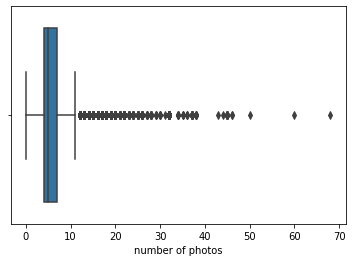

In [ ]:
sns.boxplot(df['number of photos'])

In [ ]:
df[df['number of photos'] > 15].shape[0]

788

In [ ]:
df = df[df['number of photos'] < 15]  #Удалим выбросы

#### Признаки display_address и  street_address

In [ ]:
df[['display_address', 'street_address']].head()

,display_address,street_address
4,145 Borinquen Place,145 Borinquen Place
6,East 44th,230 East 44th
9,East 56th Street,405 East 56th Street
10,Metropolitan Avenue,792 Metropolitan Avenue
15,East 34th Street,340 East 34th Street


По-видимому display_address - это улица, а street_address - это конкрентый дом на этой улице. В дальнейшем можно будет удалить признак street_address, оставив при этом только display_address.  

Выясним, сколько в датасете адресов, которым соответствует только одно объявление.

In [ ]:
df['street_address'].value_counts().shape[0]

15001

In [ ]:
A = df['street_address'].value_counts()[df['street_address'].value_counts() >= 2].shape[0]
A

6230

In [ ]:
B = df['street_address'].value_counts()[df['street_address'].value_counts() < 2].shape[0]
B

8771

In [ ]:
series = pd.Series([A,B], index = ['Количество адресов, на которые ссылаются больше 2-х объявлений ', 'Количество адресов, на которые ссылается 1 объявление'], name = 'Соотношение адресов')
series

Количество адресов, на которые ссылаются больше 2-х объявлений     6230
Количество адресов, на которые ссылается 1 объявление              8771
Name: Соотношение адресов, dtype: int64

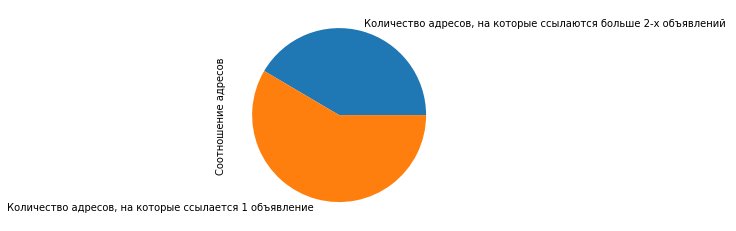

In [ ]:
series.plot.pie()

Количество адресов, на которые ссылаются по одному объявлению - 8771. Это почти что 20% данных от датасета. Избавимся от половины этих значений, чтобы модель не переучивалась и оставим популярные адреса.

###### Очищаем street_address

In [ ]:
address_list = list(df['street_address'].value_counts()[df['street_address'].value_counts() < 2].index) # создадим список 
                                                                                                        #с адресами на удаление
address_list = address_list[:int(0.5 * len(address_list))]

In [ ]:
df_list = df.to_numpy().tolist()      # переведём исходный dataframe в список, для облегчения работы с street_adress
df_list[0][13]

'145 Borinquen Place'

На всякий случай выясним, сколько объявлений по заданным адресам имеет значение interest_level = 'low'.

In [ ]:
counter = 0
for i in range(len(df_list)):
    if (df_list[i][13] in address_list) and (df_list[i][14] == 'low'):      # удаляем объявления с уникальными адресами
        counter += 1
        i +=1
counter

2521

In [ ]:
i = 0
while i < len(df_list):
    if df_list[i][13] in address_list:      # удаляем объявления с уникальными адресами
        del(df_list[i])
    else:
        i +=1

In [ ]:
df.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'interest_level',
       'date of publication', 'month of publication', 'year of publication',
       'number of photos'],
      dtype='object')

In [ ]:
df = pd.DataFrame(np.array(df_list), columns = df.columns)  # Преобразуем список обратно в dataframe

<ipython-input-49-1119333ab9eb>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(df_list), columns = df.columns)  # Преобразуем список обратно в dataframe


In [ ]:
df.shape

(43239, 19)

### Text preprocessing

Попробую поработать с текстовыми признаками 'street address',features' и 'description'.

#### Признаки description и features

Проанализируем содержимое description и features.

In [ ]:
df.iloc[100, 4]

"Absolutely stunning and spacious 2 bedroom flex in one of the most sought after white glove Condominiums in the Financial District. The apartment features gorgeous sleek finishes throughout, including stained hardwood floors, oversized windows providing plenty of natural sunlight, and immense closet space. The kitchen was designed to flow seamlessly into the living area. Dishwasher, and extra storage space that are all concealed by dark stained wood cabinetry. The rich, earthy tones throughout the unit evoke a warm and sensual feel to the space that is both welcoming and relaxing. The extra large stone bathroom boasts spa quality finishes, including ambient lighting, a deep soaking tub, Completing the picture, a wide entry hallway creates the perfect separation from the living space and allows for extra storage while the 10 ceilings create an open and grand feel throughout.Life on Water Street promises luxury, hotel quality amenities and white-glove services that include a 24 hour Doo

In [ ]:
df.iloc[100, 6]

['Dining Room',
 'Balcony',
 'Furnished',
 'Garden/Patio',
 'Terrace',
 'Laundry in Unit',
 'Dishwasher',
 'Hardwood Floors',
 'No Fee',
 'Outdoor Space']

Преобразуем признак features так, чтобы он стал строкой, вместо списка.

In [ ]:
features_list = []
for i, row in df.iterrows():
    row['features'] = ' '.join(map(str, row['features']))
    features_list.append(row['features'])
df['features_text'] = features_list
df['features_text'].head()

0    Dining Room Pre-War Laundry in Building Dishwa...
1    Doorman Elevator Laundry in Building Dishwashe...
2    Doorman Elevator Laundry in Building Laundry i...
3                                                     
4    Doorman Elevator Fitness Center Laundry in Bui...
Name: features_text, dtype: object

Как видно выше, description и features содержат большое количество символов, которые не несут никакой смысловой нагрузки. Очистим эти данные.

Напишем функцию очистки текста от ненужных спец. симолов, ссылок, чисел и лишних пробелов.

In [ ]:
def clean_text(text):
    # приводим текст к нижнему регистру
    text = text.lower()
    # создаем регулярное выражение для удаления лишних символов
    regular = r'[\*+\#+\№\"\-+\+\=+\?+\&\^\.+\;\,+\>+\(\)\/+\:\\+\!+\<+\'S\@+]'
    # регулярное выражение для замены ссылки на "URL"
    regular_url = r'(http\S+)|(www\S+)|([\w\d]+www\S+)|([\w\d]+http\S+)'
    # удаляем лишние символы
    text = re.sub(regular, '', text)
    # заменяем ссылки на "URL"
    text = re.sub(regular_url, r'URL', text)
    # заменяем числа и цифры на ' NUM '
    text = re.sub(r'(\d+\s\d+)|(\d+)',' NUM ', text)
    # удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    # возвращаем очищенные данные
    return text

Очистим description.

In [ ]:
cleaned_text = []
# загружаем список с английскими стоп-словами в переменную stop-words
stop_words = stopwords.words('english')
stop_words.append(['in','room','with','a','building','th','br','the','is','a','to'])

for text in df['description']:
    text = clean_text(text)
    text = word_tokenize(text)      # токенизируем слова
    for word in text:
        if word not in stop_words:  # удаляем стоп-слова
            pass
        else:
            text.remove(word)
    cleaned_text.append(text)
df['cleaned_description'] = cleaned_text   

In [ ]:
df['cleaned_description'].head()

0    [spacious, NUM, bedroom, NUM, bathroom, willia...
1    [brand, new, gut, renovated, true, NUM, bedroo...
2    [flex, NUM, bedroom, full, pressurized, walllo...
3    [brand, new, NUM, bedroom, NUM, bath, apartmen...
4    [oversized, studio, w, abundant, closets, avai...
Name: cleaned_description, dtype: object

Очистим features.

In [ ]:
cleaned_text = []
# создаем список для хранения токенов
# tokens = []
for text in df['features_text']:
    text = clean_text(text)
    text = word_tokenize(text)
    for word in text:
        if word not in stop_words:
            pass
        else:
            text.remove(word)
    cleaned_text.append(text)
df['cleaned_features'] = cleaned_text 

In [ ]:
df['cleaned_features'].head()

0    [dining, room, prewar, laundry, building, dish...
1    [doorman, elevator, laundry, building, dishwas...
2    [doorman, elevator, laundry, building, laundry...
3                                                   []
4    [doorman, elevator, fitness, center, laundry, ...
Name: cleaned_features, dtype: object

Очистим street_address.

In [ ]:
cleaned_text = []
for text in df['street_address']:
    text = clean_text(text)
    text = word_tokenize(text)
    for word in text:
        if word not in stop_words:
            pass
        else:
            text.remove(word)
    cleaned_text.append(text)
df['cleaned_street_address'] = cleaned_text 

In [ ]:
df['cleaned_street_address'].head()

0         [NUM, borinquen, place]
1            [NUM, east, NUM, th]
2    [NUM, east, NUM, th, street]
3     [NUM, metropolitan, avenue]
4    [NUM, east, NUM, th, street]
Name: cleaned_street_address, dtype: object

Создадим новые признаки, которые будут отображать размер описания и особенностей.

In [ ]:
df['length of description'] = df['cleaned_description'].apply(len)

In [ ]:
df['length of features'] = df['cleaned_features'].apply(len)

#### Признак length of description

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


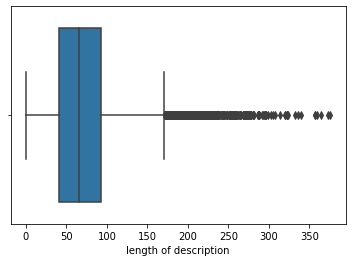

In [ ]:
sns.boxplot(df['length of description'])

In [ ]:
df[df['length of description'] > 190].shape

(688, 25)

Очистим от выбросов.

In [ ]:
df = df[df['length of description'] < 190]

#### Признак length of features

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


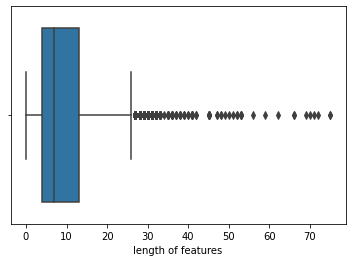

In [ ]:
sns.boxplot(df['length of features'])

In [ ]:
df[df['length of features'] > 25].shape

(752, 25)

Очистим от выбросов.

In [ ]:
df = df[df['length of features'] < 25]

#### Признак price

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


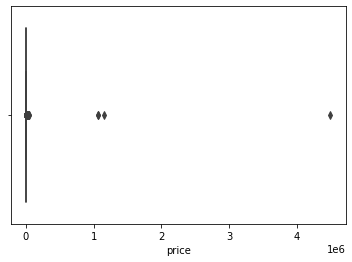

In [ ]:
sns.boxplot(df['price'])

In [ ]:
df[df['price'] > 500000].shape[0]

4

In [ ]:
df = df[df['price'] < 500000]

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


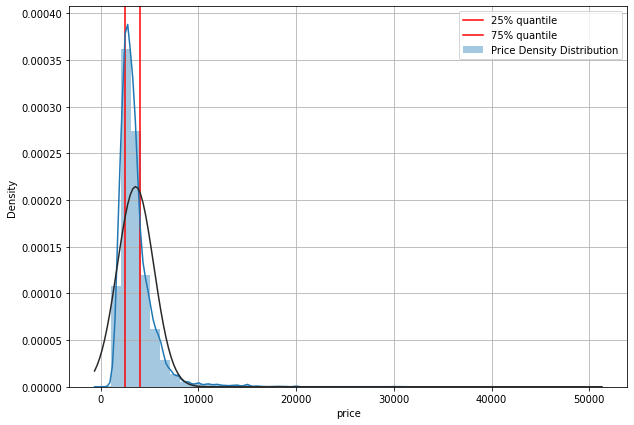

In [ ]:
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(1,1,1)
plt.axvline(df['price'].quantile(0.25), label = '25% quantile', color = 'red')
plt.axvline(df['price'].quantile(0.75), label = '75% quantile', color = 'red')
sns.distplot(df['price'], label = 'Price Density Distribution', fit = norm)
plt.legend()
plt.grid(True)

In [ ]:
df[df['price'] > 10000].shape[0]

520

In [ ]:
df = df[df['price'] < 10000]

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


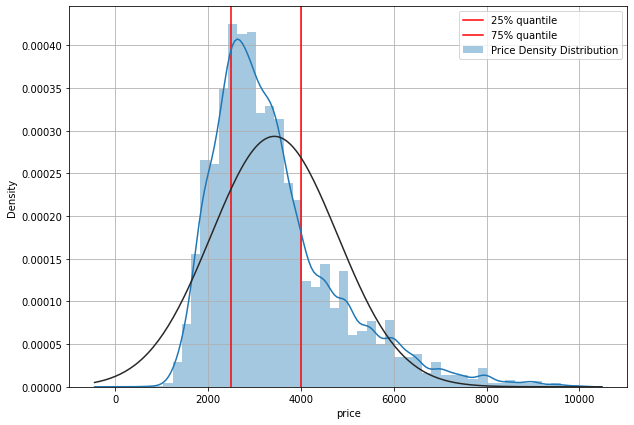

In [ ]:
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(1,1,1)
plt.axvline(df['price'].quantile(0.25), label = '25% quantile', color = 'red')
plt.axvline(df['price'].quantile(0.75), label = '75% quantile', color = 'red')
sns.distplot(df['price'], label = 'Price Density Distribution', fit = norm)
plt.legend()
plt.grid(True)

#### Признак interest_level

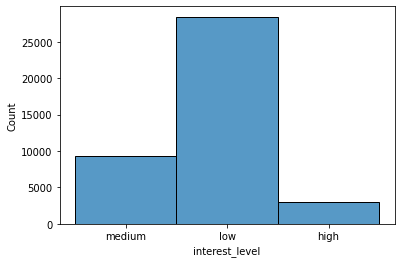

In [ ]:
sns.histplot(data= df, x='interest_level')

In [ ]:
df = df.replace({'interest_level' : { 'high' : 0, 'medium' : 1, 'low' : 2 }})

In [ ]:
print(df.columns)

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'interest_level',
       'date of publication', 'month of publication', 'year of publication',
       'number of photos', 'features_text', 'cleaned_description',
       'cleaned_features', 'cleaned_street_address', 'length of description',
       'length of features'],
      dtype='object')


Удалим ненужные признаки.

In [ ]:
cols_2_drop = ['building_id', 'created', 'description', 'display_address', 'features', 'listing_id',\
               'manager_id', 'photos','street_address','date of publication', 'year of publication', 'features_text']

In [ ]:
df = df.drop(cols_2_drop, axis = 1)

In [ ]:
print(df.columns)

Index(['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price',
       'interest_level', 'month of publication', 'number of photos',
       'cleaned_description', 'cleaned_features', 'cleaned_street_address',
       'length of description', 'length of features'],
      dtype='object')


In [ ]:
df.shape

(40865, 13)

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40865 entries, 0 to 43238
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   bathrooms               40865 non-null  object
 1   bedrooms                40865 non-null  object
 2   latitude                40865 non-null  object
 3   longitude               40865 non-null  object
 4   price                   40865 non-null  object
 5   interest_level          40865 non-null  int64 
 6   month of publication    40865 non-null  object
 7   number of photos        40865 non-null  object
 8   cleaned_description     40865 non-null  object
 9   cleaned_features        40865 non-null  object
 10  cleaned_street_address  40865 non-null  object
 11  length of description   40865 non-null  int64 
 12  length of features      40865 non-null  int64 
dtypes: int64(3), object(10)
memory usage: 4.4+ MB
None


Видимо, в результате работы с признаком street_address слетели типы данных признаков. Зададим их снова

In [ ]:
df['bathrooms'] = df['bathrooms'].astype('int32')
df['bedrooms'] = df['bedrooms'].astype('int32')
df['latitude'] = df['latitude'].astype('float64')
df['longitude'] = df['longitude'].astype('float64')
df['price'] = df['price'].astype('int64')
df['month of publication'] = df['month of publication'].astype('int32')
df['number of photos'] = df['number of photos'].astype('int32')

Взглянем на матрицу корреляций.

<ipython-input-90-378bc476c9b9>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1,1,1)


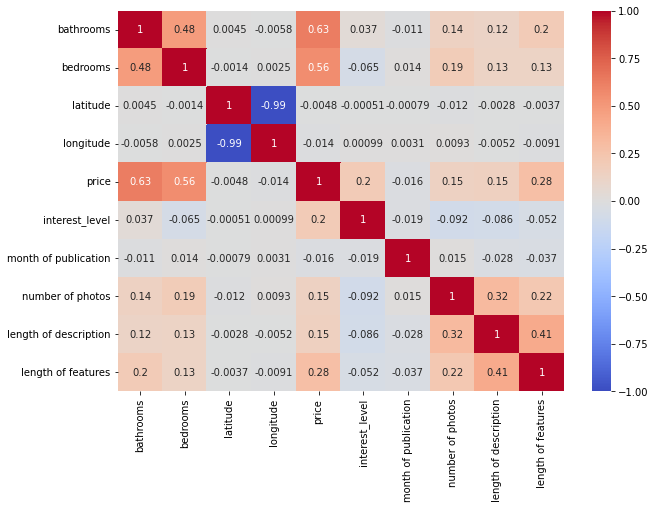

In [ ]:
plt.figure(figsize = (10,7))
ax = fig.add_subplot(1,1,1)
sns.heatmap(df.corr(), cmap = sns.color_palette('coolwarm', 10000), vmin = -1, center = 0, annot = True)
plt.show()

Видим, что признаки либо умеренно коррелируют, либо вообще не коррелируют между собой. Ни один из признаков напрямую не зависит от других.

#### Test dataset

Проделаем основные шаги с тестовой выборкой.

In [ ]:
test_df = pd.read_json('/test.json')

In [ ]:
test_df.shape

(74659, 14)

In [ ]:
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74659 entries, 0 to 124010
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        74659 non-null  float64
 1   bedrooms         74659 non-null  int64  
 2   building_id      74659 non-null  object 
 3   created          74659 non-null  object 
 4   description      74659 non-null  object 
 5   display_address  74659 non-null  object 
 6   features         74659 non-null  object 
 7   latitude         74659 non-null  float64
 8   listing_id       74659 non-null  int64  
 9   longitude        74659 non-null  float64
 10  manager_id       74659 non-null  object 
 11  photos           74659 non-null  object 
 12  price            74659 non-null  int64  
 13  street_address   74659 non-null  object 
dtypes: float64(3), int64(3), object(8)
memory usage: 8.5+ MB
None


In [ ]:
test_df['bathrooms'] = test_df['bathrooms'].astype('int')
test_df['date of publication'] = pd.to_datetime(test_df['created'], errors = 'coerce')
test_df['month of publication'] = test_df['date of publication'].dt.month.astype('int')
test_df['number of photos'] = test_df['photos'].apply(len)

In [ ]:
features_list = []
for i, row in test_df.iterrows():
    row['features'] = ' '.join(map(str, row['features']))
    features_list.append(row['features'])
test_df['features_text'] = features_list
test_df['features_text'].head()

0    Elevator Laundry in Building Laundry in Unit D...
1                    Pre-War Dogs Allowed Cats Allowed
2                    Pre-War Dogs Allowed Cats Allowed
3            Hardwood Floors Dogs Allowed Cats Allowed
5    Roof Deck Doorman Elevator Fitness Center Pre-...
Name: features_text, dtype: object

In [ ]:
cleaned_text = []
# загружаем список с английскими стоп-словами в переменную stop-words
stop_words = stopwords.words('english')
stop_words.append(['in','room','with','a','building','th','br','the','is','a','to'])

for text in test_df['description']:
    text = clean_text(text)
    text = word_tokenize(text)      # токенизируем слова
    for word in text:
        if word not in stop_words:  # удаляем стоп-слова
            pass
        else:
            text.remove(word)
    cleaned_text.append(text)
test_df['cleaned_description'] = cleaned_text 

In [ ]:
cleaned_text = []
# создаем список для хранения токенов
# tokens = []
for text in test_df['features_text']:
    text = clean_text(text)
    text = word_tokenize(text)
    for word in text:
        if word not in stop_words:
            pass
        else:
            text.remove(word)
    cleaned_text.append(text)
test_df['cleaned_features'] = cleaned_text

In [ ]:
cleaned_text = []
for text in test_df['street_address']:
    text = clean_text(text)
    text = word_tokenize(text)
    for word in text:
        if word not in stop_words:
            pass
        else:
            text.remove(word)
    cleaned_text.append(text)
test_df['cleaned_street_address'] = cleaned_text

In [ ]:
test_df['length of description'] = test_df['cleaned_description'].apply(len)
test_df['length of features'] = test_df['cleaned_features'].apply(len)

In [ ]:
cols_2_drop = ['building_id', 'created', 'description', 'display_address', 'features', 'listing_id',\
               'manager_id', 'photos','street_address','date of publication', 'features_text']

In [ ]:
test_df = test_df.drop(cols_2_drop, axis = 1)

In [ ]:
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74659 entries, 0 to 124010
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bathrooms               74659 non-null  int64  
 1   bedrooms                74659 non-null  int64  
 2   latitude                74659 non-null  float64
 3   longitude               74659 non-null  float64
 4   price                   74659 non-null  int64  
 5   month of publication    74659 non-null  int64  
 6   number of photos        74659 non-null  int64  
 7   cleaned_description     74659 non-null  object 
 8   cleaned_features        74659 non-null  object 
 9   cleaned_street_address  74659 non-null  object 
 10  length of description   74659 non-null  int64  
 11  length of features      74659 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 7.4+ MB
None


### Финальная часть

In [ ]:
X_train = df.drop('interest_level', axis = 1)

In [ ]:
y_train = df['interest_level']

In [ ]:
X_test = test_df


In [ ]:
# Переводим в строковые значения train

cleaned_description_list = []
for i, row in X_train.iterrows():
    row['cleaned_description'] = ' '.join(map(str, row['cleaned_description']))
    cleaned_description_list.append(row['cleaned_description'])
X_train['cleaned_description'] = cleaned_description_list

cleaned_feature_list = []
for i, row in X_train.iterrows():
    row['cleaned_features'] = ' '.join(map(str, row['cleaned_features']))
    cleaned_feature_list.append(row['cleaned_features'])
X_train['cleaned_features'] = cleaned_feature_list

cleaned_address_list = []
for i, row in X_train.iterrows():
    row['cleaned_street_address'] = ' '.join(map(str, row['cleaned_street_address']))
    cleaned_address_list.append(row['cleaned_street_address'])
X_train['cleaned_street_address'] = cleaned_address_list

In [ ]:
# Переводим в строковые значения test
cleaned_description_list = []
for i, row in X_test.iterrows():
    row['cleaned_description'] = ' '.join(map(str, row['cleaned_description']))
    cleaned_description_list.append(row['cleaned_description'])
X_test['cleaned_description'] = cleaned_description_list

cleaned_feature_list = []
for i, row in X_test.iterrows():
    row['cleaned_features'] = ' '.join(map(str, row['cleaned_features']))
    cleaned_feature_list.append(row['cleaned_features'])
X_test['cleaned_features'] = cleaned_feature_list

cleaned_address_list = []
for i, row in X_test.iterrows():
    row['cleaned_street_address'] = ' '.join(map(str, row['cleaned_street_address']))
    cleaned_address_list.append(row['cleaned_street_address'])
X_test['cleaned_street_address'] = cleaned_address_list

В качестве модели буду использовать Catboost. Данная модель основана на алгоритме градиентного бустинга. Преимущество catboost в том, что он может работать как с категориальными, так и с текстовыми признаками.

In [ ]:
# scaler = StandardScaler()
# X_train[['bathrooms', 'bedrooms', 'latitude', 'longitude','price','month of publication','number of photos', \
#          'length of description', 'length of features']] = scaler.fit_transform(X_train[['bathrooms', 'bedrooms', \
#             'latitude', 'longitude','price','month of publication', \
#             'number of photos', 'length of description', 'length of features']])



In [ ]:
# X_test[['bathrooms', 'bedrooms', 'latitude', 'longitude','price','month of publication','number of photos', \
#          'length of description', 'length of features']] = scaler.transform(X_test[['bathrooms', 'bedrooms', \
#             'latitude', 'longitude','price','month of publication', \
#             'number of photos', 'length of description', 'length of features']])
# X_test.head()

In [ ]:
category_features = ['month of publication']
text_features = ['cleaned_description','cleaned_features' , 'cleaned_street_address']

In [ ]:
parameters = {'loss_function': 'MultiClass',
              'random_seed': 42,
              'verbose': False,
              'learning_rate': 0.5,
              'depth': 6,
              'n_estimators': 1000,
              'task_type': 'GPU'}

In [ ]:
Train = Pool(data = X_train,
             label = y_train,
             cat_features = category_features,
             text_features = text_features)

In [ ]:
model = CatBoostClassifier(**parameters)

In [ ]:
model.fit(Train)

In [ ]:
Test = Pool(data = X_test,
             cat_features = category_features,
             text_features = text_features)

In [ ]:
predictions_train = model.predict_proba(Train)

In [ ]:
predictions_test = model.predict_proba(Test)

In [ ]:
pred = pd.DataFrame(predictions_test)
pred.head()

,0,1,2
0,0.058929,0.482576,0.458495
1,0.197604,0.223931,0.578465
2,0.005745,0.022476,0.971778
3,0.183400,0.331954,0.484646
4,0.046665,0.242673,0.710662


In [ ]:
submission = pd.read_csv('/content/sample_submission.csv')
submission.head()

,listing_id,high,medium,low
0,7142618,0.077788,0.227529,0.694683
1,7210040,0.077788,0.227529,0.694683
2,7174566,0.077788,0.227529,0.694683
3,7191391,0.077788,0.227529,0.694683
4,7171695,0.077788,0.227529,0.694683


In [ ]:
submission['high'] = pred[0]
submission['medium'] = pred[1]
submission['low'] = pred[2]
submission.to_csv('cft_late_submission.csv', index = False)